### 1. Import the relevant libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
import sklearn as sk
import category_encoders as ce
from sklearn.pipeline import Pipeline

### 2. Import the data files

In [3]:
sales_df = pd.read_csv('data/sales_train_validation.csv')

### 3. Explore the data

In [4]:
sales_df.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### 3.A. Sales data review

In [5]:
# List the columns
first_day = 'd_1'
last_day = 'd_1913'
print (f'There are {len(sales_df.columns)} columns in the sales_train_validation data.\n')
print(sales_df.columns)

There are 1919 columns in the sales_train_validation data.

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1',
       'd_2', 'd_3', 'd_4',
       ...
       'd_1904', 'd_1905', 'd_1906', 'd_1907', 'd_1908', 'd_1909', 'd_1910',
       'd_1911', 'd_1912', 'd_1913'],
      dtype='object', length=1919)


In [6]:
# Look at the statistics
summary = sales_df.describe(include='all').T
summary

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,30490,30490,FOODS_1_200_CA_2_validation,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
item_id,30490,3049,FOODS_2_280,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dept_id,30490,7,FOODS_3,8230,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cat_id,30490,3,FOODS,14370,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store_id,30490,10,TX_1,3049,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
d_1909,30490,NaN,NaN,NaN,1.15917,2.87603,0,0,0,1,88
d_1910,30490,NaN,NaN,NaN,1.149,2.95036,0,0,0,1,77
d_1911,30490,NaN,NaN,NaN,1.32886,3.35801,0,0,0,1,141
d_1912,30490,NaN,NaN,NaN,1.60584,4.08942,0,0,0,2,171


#### Identify the categorical variables

In [7]:
# Identify the non-numerical columns
categorical_columns = sales_df.select_dtypes('object').columns
categorical_columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], dtype='object')

In [8]:
# Identify the unique number of values in each column
summary.unique[categorical_columns]

id          30490
item_id      3049
dept_id         7
cat_id          3
store_id       10
state_id        3
Name: unique, dtype: object

In [9]:
# Print the catgorical columns for further evaluation
categorical_df_sales = sales_df.loc[:,sales_df.dtypes=='object'].set_index('id')
categorical_df_sales.head()

,item_id,dept_id,cat_id,store_id,state_id
id,,,,,
HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA
HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA
HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA
HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA
HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA


Text(0.5, 1.0, 'state_id')

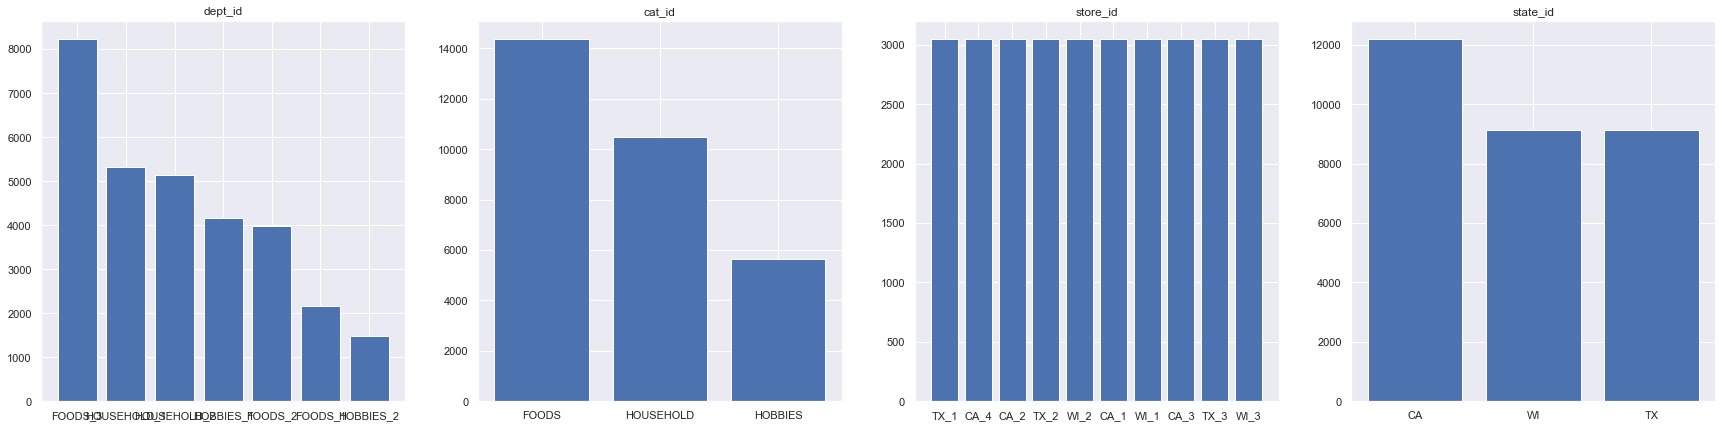

In [10]:
# Graph the distribution of categorical variables
data = sales_df.copy()

# Id and Item_Id columns are to be used for indexing

fig,([f1,f2,f3,f4]) = plt.subplots(1,4, figsize=(30,7))

f1.bar(data[categorical_columns[2]].value_counts().index, data[categorical_columns[2]].value_counts())
f1.set_title(categorical_columns[2])

f2.bar(data[categorical_columns[3]].value_counts().index, data[categorical_columns[3]].value_counts())
f2.set_title(categorical_columns[3])

f3.bar(data[categorical_columns[4]].value_counts().index, data[categorical_columns[4]].value_counts())
f3.set_title(categorical_columns[4])

f4.bar(data[categorical_columns[5]].value_counts().index, data[categorical_columns[5]].value_counts())
f4.set_title(categorical_columns[5])


### 3.A.i. Encode the categorical variables

In [11]:
# import the necessary libraries
from category_encoders import OneHotEncoder, LeaveOneOutEncoder, BinaryEncoder, OrdinalEncoder

#### 3.A.i.a. One hot encode the variables

In [12]:
# list the categorical columns to be encoded
categorical_columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], dtype='object')

In [13]:
# Select the columns to be one hot encoded from the dataset
categorical_sales_df = sales_df[['dept_id', 'cat_id', 'store_id', 'state_id']]

In [14]:
# Initialize a dataframe to store the onehot encoded columns
oh_encoded_categorical_columns = pd.DataFrame() 

In [15]:
# Create a onehotencoder instance
encoder_category = OneHotEncoder()  

oh_encoded_dept = encoder_category.fit_transform(categorical_sales_df.iloc[:,0])

# Encode and join to the oh_encoded_categorical_columns
oh_encoded_categorical_columns = oh_encoded_categorical_columns.join(oh_encoded_dept, how='outer')


In [16]:
#Review the result
oh_encoded_categorical_columns.head()

,dept_id_1,dept_id_2,dept_id_3,dept_id_4,dept_id_5,dept_id_6,dept_id_7
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [17]:
# encode the next categorical column: cat_id

# Create a onehotencoder instance
encoder_category = OneHotEncoder()  
oh_encoded_cat_id = encoder_category.fit_transform(categorical_sales_df.iloc[:,1])

# Join the encoded columns with the intialized dataframe
oh_encoded_categorical_columns = oh_encoded_categorical_columns.join(oh_encoded_cat_id, how='outer')

# Preview the results
oh_encoded_categorical_columns

,dept_id_1,dept_id_2,dept_id_3,dept_id_4,dept_id_5,dept_id_6,dept_id_7,cat_id_1,cat_id_2,cat_id_3
0,1,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
30485,0,0,0,0,0,0,1,0,0,1
30486,0,0,0,0,0,0,1,0,0,1
30487,0,0,0,0,0,0,1,0,0,1
30488,0,0,0,0,0,0,1,0,0,1


In [18]:
# encode the next categorical column: store_id

# Create a onehotencoder instance
encoder_category = OneHotEncoder()  
oh_encoded_store_id = encoder_category.fit_transform(categorical_sales_df.iloc[:,2])

# Join the encoded columns with the intialized dataframe
oh_encoded_categorical_columns = oh_encoded_categorical_columns.join(oh_encoded_store_id, how='outer')

# Preview the results
oh_encoded_categorical_columns

,dept_id_1,dept_id_2,dept_id_3,dept_id_4,dept_id_5,dept_id_6,dept_id_7,cat_id_1,cat_id_2,cat_id_3,store_id_1,store_id_2,store_id_3,store_id_4,store_id_5,store_id_6,store_id_7,store_id_8,store_id_9,store_id_10
0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
30486,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
30487,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
30488,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1


In [19]:
# encode the next categorical column: state_id

# Create a onehotencoder instance
encoder_category = OneHotEncoder()  
oh_encoded_state_id = encoder_category.fit_transform(categorical_sales_df.iloc[:,3])
                               
# Join the encoded columns with the intialized dataframe
oh_encoded_categorical_columns = oh_encoded_categorical_columns.join(oh_encoded_state_id, how='outer')

# Preview the results
oh_encoded_categorical_columns

,dept_id_1,dept_id_2,dept_id_3,dept_id_4,dept_id_5,dept_id_6,dept_id_7,cat_id_1,cat_id_2,cat_id_3,...,store_id_4,store_id_5,store_id_6,store_id_7,store_id_8,store_id_9,store_id_10,state_id_1,state_id_2,state_id_3
0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
30486,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
30487,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
30488,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1


#### 3.A.i.b. Binary encode the item_id columns

In [20]:
# item_id column has more than 3000 unique values, and binary encoding will have to do

# Create a binary encoder instance
encoder_binary = BinaryEncoder()

# Save the result to a new dataframe
bin_encoded_categorical_columns = encoder_binary.fit_transform(sales_df.item_id)



# Join the encoded columns with the intialized dataframe
oh_encoded_categorical_columns = oh_encoded_categorical_columns.join(bin_encoded_categorical_columns, how='left')

# Preview the results
oh_encoded_categorical_columns

,dept_id_1,dept_id_2,dept_id_3,dept_id_4,dept_id_5,dept_id_6,dept_id_7,cat_id_1,cat_id_2,cat_id_3,...,item_id_3,item_id_4,item_id_5,item_id_6,item_id_7,item_id_8,item_id_9,item_id_10,item_id_11,item_id_12
0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
3,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,0,0,0,0,0,0,1,0,0,1,...,1,1,1,1,1,0,0,1,0,1
30486,0,0,0,0,0,0,1,0,0,1,...,1,1,1,1,1,0,0,1,1,0
30487,0,0,0,0,0,0,1,0,0,1,...,1,1,1,1,1,0,0,1,1,1
30488,0,0,0,0,0,0,1,0,0,1,...,1,1,1,1,1,0,1,0,0,0


In [21]:
# item_id column has more than 3000 unique values, and I will include an ordinal encoded column, too 
#for easier sorting, graphing down the line

# Create a binary encoder instance
encoder_ord = OrdinalEncoder()

# Save the result to a new dataframe
ordinal_encoded_categorical_columns = encoder_ord.fit_transform(sales_df.item_id)

# Preview the results
oh_encoded_categorical_columns['item_id_#'] = ordinal_encoded_categorical_columns
oh_encoded_categorical_columns

,dept_id_1,dept_id_2,dept_id_3,dept_id_4,dept_id_5,dept_id_6,dept_id_7,cat_id_1,cat_id_2,cat_id_3,...,item_id_4,item_id_5,item_id_6,item_id_7,item_id_8,item_id_9,item_id_10,item_id_11,item_id_12,item_id_#
0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,2
2,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,3
3,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,4
4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,0,0,0,0,0,0,1,0,0,1,...,1,1,1,1,0,0,1,0,1,3045
30486,0,0,0,0,0,0,1,0,0,1,...,1,1,1,1,0,0,1,1,0,3046
30487,0,0,0,0,0,0,1,0,0,1,...,1,1,1,1,0,0,1,1,1,3047
30488,0,0,0,0,0,0,1,0,0,1,...,1,1,1,1,0,1,0,0,0,3048


In [22]:
# Join the sales_train_validation_df and oh_encoded variables df to a new df
encoded_sales_df = sales_df.join(oh_encoded_categorical_columns, how='outer')

# Preview the new dataframe
encoded_sales_df

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,item_id_4,item_id_5,item_id_6,item_id_7,item_id_8,item_id_9,item_id_10,item_id_11,item_id_12,item_id_#
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,1,1,3
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,1,0,0,4
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,1,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,1,1,1,0,0,1,0,1,3045
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,1,0,0,1,1,0,3046
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,1,1,1,1,0,0,1,1,1,3047
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,1,0,1,0,0,0,3048


#### 3.A.iii. Reorganize the columns

In [23]:
# Determine where the encoded columns start
encoded_sales_df.columns.get_loc(first_day), encoded_sales_df.columns.get_loc(last_day)

(6, 1918)

In [24]:
list(enumerate(encoded_sales_df.columns))[:10]

[(0, 'id'),
 (1, 'item_id'),
 (2, 'dept_id'),
 (3, 'cat_id'),
 (4, 'store_id'),
 (5, 'state_id'),
 (6, 'd_1'),
 (7, 'd_2'),
 (8, 'd_3'),
 (9, 'd_4')]

In [25]:
encoded_sales_df.columns.get_loc('item_id_#')

1955

In [26]:
encoded_sales_df.columns[6:1919]

Index(['d_1', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'd_8', 'd_9', 'd_10',
       ...
       'd_1904', 'd_1905', 'd_1906', 'd_1907', 'd_1908', 'd_1909', 'd_1910',
       'd_1911', 'd_1912', 'd_1913'],
      dtype='object', length=1913)

In [27]:
encoded_sales_df.columns[1919:-1]

Index(['dept_id_1', 'dept_id_2', 'dept_id_3', 'dept_id_4', 'dept_id_5',
       'dept_id_6', 'dept_id_7', 'cat_id_1', 'cat_id_2', 'cat_id_3',
       'store_id_1', 'store_id_2', 'store_id_3', 'store_id_4', 'store_id_5',
       'store_id_6', 'store_id_7', 'store_id_8', 'store_id_9', 'store_id_10',
       'state_id_1', 'state_id_2', 'state_id_3', 'item_id_0', 'item_id_1',
       'item_id_2', 'item_id_3', 'item_id_4', 'item_id_5', 'item_id_6',
       'item_id_7', 'item_id_8', 'item_id_9', 'item_id_10', 'item_id_11',
       'item_id_12'],
      dtype='object')

In [28]:
# Reorder columns
# id, item_id, original categorical data, encoded categorical data, daily sales
columns_order = ['id', 'item_id_#'] + list(encoded_sales_df.columns[1:6]) +\
list(encoded_sales_df.columns[1919:-1]) + list(encoded_sales_df.columns[6:1919])

In [29]:
# Update the encoded dataframe
encoded_sales_df = encoded_sales_df[columns_order]

In [30]:
# Preview the results
encoded_sales_df.head()

,id,item_id_#,item_id,dept_id,cat_id,store_id,state_id,dept_id_1,dept_id_2,dept_id_3,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,2,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,3,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,4,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,5,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0,0,...,2,1,1,0,1,1,2,2,2,4


In [31]:
# Finalize the sales_train_validation
sales_final_df = encoded_sales_df.copy()

## Uncomment line below to export the data

In [32]:
# Write the final sales_train_validation data to csv
sales_final_df.to_csv('temp/M5_preprocessed_sales-v1.csv')